Below, I install my own implementation of Professor Boonstra's "memoize DataFrame to disk" feature. The source code can be found at [github.com/ethho/memoize](https://github.com/ethho/memoize).

In [1]:
!python3 -m pip install --quiet git+https://github.com/ethho/memoize.git

In [156]:
import json
import re
import os
from glob import glob
from dataclasses import dataclass
from collections.abc import Sequence
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm, probplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import quandl
import functools
import plotly.express as px
import plotly.graph_objects as go
from memoize.dataframe import memoize_df

%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

DARK_MODE = False
# TODO

# 20230217_hw6_ho_ethan_12350006

@mpcs
@finm33550

Ethan Ho 2/17/2023

----

## Configuration & Helper Functions

The following cell contains helper functions and configuration options that I will use in this notebook.

In [3]:
def get_secrets(fp='./secrets.json'):
    """
    Reads secret values such as API keys from a JSON-formatted file at `fp`.
    """
    with open(fp, 'r') as f:
        data = json.load(f)
    return data

def get_quandl_api_key() -> str:
    """
    Returns Quandl API key stored in secrets.json.
    """
    secrets = get_secrets()
    key = secrets.get('NASTAQ_DATA_API_KEY')
    assert key, f"NASTAQ_DATA_API_KEY field in secrets.json is empty or does not exist"
    return key

def strip_str_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame, strips values in columns with string or object
    dtype. I noticed that this was an issue when I saw some m_ticker values
    like "AAPL       " with trailing whitespace.
    """
    for col in df.columns:
        if pd.api.types.is_string_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
            df[col] = df[col].str.strip()
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_table(
    name, start_date, end_date, **kw
) -> pd.DataFrame:
    df = quandl.get_table(
        name,
        date={'gte': start_date, 'lte': end_date},
        api_key=get_quandl_api_key(),
        paginate=True,
        **kw
    )
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)
    df.reset_index(inplace=True)
    return df

@memoize_df(cache_dir='data/memoize', cache_lifetime_days=None)
def fetch_quandl_quotemedia_prices(
    start_date, end_date, ticker
) -> pd.DataFrame:
    return fetch_quandl_table(
        name= 'QUOTEMEDIA/PRICES',
        start_date=start_date,
        end_date=end_date,
        ticker=ticker,
    )

def unique_index_keys(df, level=0) -> List[str]:
    return df.index.get_level_values(level=level).unique().tolist()

def get_next_day_of_week(date, day_of_week: int) -> str:
    """
    Monday = 0, Wednesday = 2
    """
    as_dt = pd.to_datetime(date)
    days_until = (day_of_week - as_dt.day_of_week) % 7
    out_dt = as_dt + pd.to_timedelta(days_until, 'D')
    return out_dt.strftime('%Y-%m-%d')

# Fetch Data

First, let's set our time indices. We choose to trade weekly on Wednesdays, and skip the week if the Wednesday falls on a holiday.

In [4]:
start_date = '2017-12-23'
end_date = '2022-12-30'

daily_idx = pd.date_range(start_date, end_date)
first_wed = get_next_day_of_week(start_date, 2)
wed_idx_w_holidays = pd.date_range(first_wed, end_date, freq='7D')
assert all(date.day_of_week == 2 for date in wed_idx_w_holidays)

wed_idx = [
    date for date in wed_idx_w_holidays
    if date not in pd.to_datetime([
        # Remove Wednesdays that fall on holidays
        '2012-12-26', '2013-12-25', '2014-01-01', '2018-12-26',
        '2019-12-25', '2020-01-01',
    ])
]
assert len(wed_idx_w_holidays) > len(wed_idx)

Now we load the 5 year CDS rates:

In [8]:
impliedratingmap = {
    'AA': 5,
    'A': 4,
    'BBB': 3,
    'BB': 2,
    'B': 1,
}

@memoize_df(cache_dir='./data/memoize', cache_lifetime_days=None)
def _get_cds_quotes(fp='./data/Liq5YCDS.delim'):
    df = pd.read_csv(fp, delim_whitespace=True)
    assert not df.isnull().any().any()
    df.drop(columns=['docclause', 'tier', 'currency', 'tenor'], inplace=True)
    df['ticker'] = df['ticker'].str.upper().str.strip()
    assert not df.duplicated(['date', 'ticker']).any()
    df['impliedrating'] = df['impliedrating'].apply(lambda x: impliedratingmap[x]).astype(int)
    return df

def get_cds_quotes(fp='./data/Liq5YCDS.delim'):
    df = _get_cds_quotes(fp)
    df['date'] = pd.to_datetime(df['date'])
    df = df.convert_dtypes()
    df.sort_values(by=['date', 'ticker'], inplace=True)
    df['next_wed'] = pd.to_datetime(df['date'].apply(get_next_day_of_week, args=(1, )))
    df = df.groupby(['ticker', 'next_wed'], group_keys=True).aggregate('last')
    df.drop(columns=['date'], inplace=True)
    df.index.set_names(['ticker', 'date'], inplace=True)
    assert not df.isnull().any().any()
    return df

def get_cds_return():
    df = get_cds_quotes()[['parspread']]
    sh = df.groupby(level=0).shift(1)
    change = 1 + ((df - sh) / sh)
    change.rename(columns={col: f"{col}_ret" for col in change.columns}, inplace=True)
    df = df.merge(change, how='left', left_index=True, right_index=True)
    return df


cds = get_cds_return()
cds

Using cache fp='./data/memoize/_get_cds_quotes_558128f_20230216.csv' to write results of function _get_cds_quotes
Using cached call from ./data/memoize/_get_cds_quotes_558128f_20230215.csv


parspread  parspread_ret
ticker date                                
BA     2018-01-02     0.0018           <NA>
       2018-01-09     0.0016         0.8847
       2018-01-16     0.0017         1.0939
       2018-01-23     0.0018         1.0296
       2018-01-30     0.0017         0.9890
...                      ...            ...
XRX    2022-12-06     0.0424         1.0050
       2022-12-13     0.0410         0.9680
       2022-12-20     0.0422         1.0286
       2022-12-27     0.0424         1.0046
       2023-01-03     0.0423         0.9987

[3838 rows x 2 columns]

Now, we fetch adjusted close prices for the corresponding equities:

In [6]:
tickers = cds.index.get_level_values(0).unique().tolist() + ['SPY']

def get_eod_quotes():
    eod_dict = dict()
    for ticker in tickers:
        eod = fetch_quandl_quotemedia_prices(
            start_date=start_date,
            end_date=end_date,
            ticker=ticker,
        )
        eod = eod[[
            'date',
            'adj_close',
        ]]
        eod['date'] = pd.to_datetime(eod['date'])
        eod.rename(columns=dict(adj_close=ticker), inplace=True)
        eod = eod.set_index('date')[ticker]
        eod.name = ticker
        eod.sort_index(inplace=True)
        eod_dict[ticker] = eod
    df = pd.DataFrame(eod_dict)
    df = df.reset_index().convert_dtypes()
    df.sort_values(by=['date'], inplace=True)
    df['next_wed'] = pd.to_datetime(df['date'].apply(get_next_day_of_week, args=(1, )))
    df = df.groupby('next_wed', group_keys=True).aggregate('last')
    df.drop(columns=['date'], inplace=True)
    df = df.stack().swaplevel().to_frame(name='eod')
    df.index.set_names(['ticker', 'date'], inplace=True)
    df.sort_index(level=[0, 1], inplace=True)
    assert not df.isnull().any().any()
    return df

def get_eod_return():
    df = get_eod_quotes()
    sh = df.groupby(level=0).shift(1)
    change = 1 + ((df - sh) / sh)
    change.rename(columns={col: f"{col}_ret" for col in change.columns}, inplace=True)
    df = df.merge(change, how='left', left_index=True, right_index=True)
    return df

eod = get_eod_return()
eod#.loc[(slice(None), '2019-01-08'), :].head(3)

Using cache fp='data/memoize/fetch_quandl_quotemedia_prices_52347df_20230216.csv' to write results of function fetch_quandl_quotemedia_prices
Using cached call from data/memoize/fetch_quandl_quotemedia_prices_52347df_20230215.csv
Using cache fp='data/memoize/fetch_quandl_quotemedia_prices_913c85c_20230216.csv' to write results of function fetch_quandl_quotemedia_prices
Using cached call from data/memoize/fetch_quandl_quotemedia_prices_913c85c_20230215.csv
Using cache fp='data/memoize/fetch_quandl_quotemedia_prices_040b924_20230216.csv' to write results of function fetch_quandl_quotemedia_prices
Using cached call from data/memoize/fetch_quandl_quotemedia_prices_040b924_20230215.csv
Using cache fp='data/memoize/fetch_quandl_quotemedia_prices_8477762_20230216.csv' to write results of function fetch_quandl_quotemedia_prices
Using cached call from data/memoize/fetch_quandl_quotemedia_prices_8477762_20230215.csv
Using cache fp='data/memoize/fetch_quandl_quotemedia_prices_122b182_20230216.csv

eod  eod_ret
ticker date                        
BA     2017-12-26 281.4210     <NA>
       2018-01-02 282.8312   1.0050
       2018-01-09 303.4022   1.0727
       2018-01-16 319.3427   1.0525
       2018-01-23 319.7524   1.0013
...                    ...      ...
XRX    2022-12-06  15.3300   0.9796
       2022-12-13  16.5300   1.0783
       2022-12-20  14.7100   0.8899
       2022-12-27  14.7000   0.9993
       2023-01-03  14.6000   0.9932

[4208 rows x 2 columns]

In [7]:
eod.loc[(slice(None), slice(None, '2018-01-09')), :].head(10)

eod  eod_ret
ticker date                        
BA     2017-12-26 281.4210     <NA>
       2018-01-02 282.8312   1.0050
       2018-01-09 303.4022   1.0727
C      2017-12-26  63.4956     <NA>
       2018-01-02  63.1389   0.9944
       2018-01-09  63.9456   1.0128
DD     2017-12-26  92.8490     <NA>
       2018-01-02  93.4468   1.0064
       2018-01-09  97.9177   1.0478
F      2017-12-26   9.8221     <NA>

In [260]:
r_E = eod.loc[('BA', slice(None)), :][['eod_ret']]
firstn = r_E.iloc[1:17]
firstn

eod_ret
ticker date               
BA     2018-01-02   1.0050
       2018-01-09   1.0727
       2018-01-16   1.0525
       2018-01-23   1.0013
       2018-01-30   1.0063
       2018-02-06   1.0095
       2018-02-13   1.0118
       2018-02-20   1.0297
       2018-02-27   1.0320
       2018-03-06   0.9569
       2018-03-13   0.9706
       2018-03-20   0.9969
       2018-03-27   0.9511
       2018-04-03   1.0302
       2018-04-10   1.0121
       2018-04-17   1.0056

ols.coef=-0.002791552900945214 ols.icpt=1.0299579383685284 ols.r2=0.17476611040530698


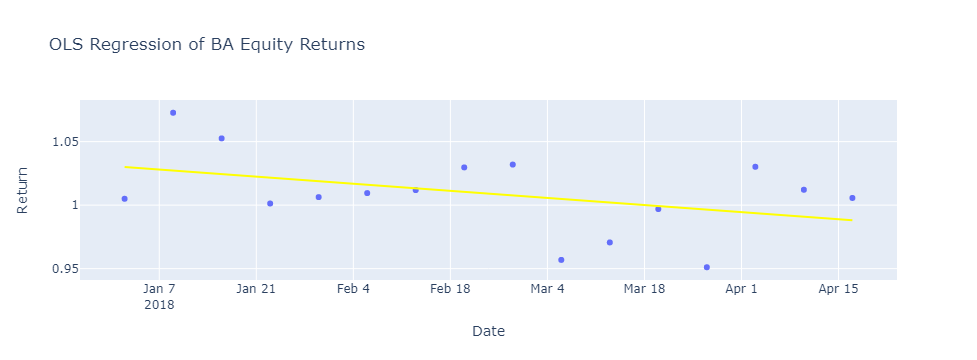

In [263]:
class OLS:
    """
    Wrapper class for sklearn.linear_model.LinearRegression.
    """
    
    def __init__(self):
        self.reg = LinearRegression()
    
    def _get_shape(self, x):
        return getattr(x, 'shape', tuple([len(x)]))
    
    def _dt_to_weeks(self, x):
        ser = pd.Series(x)
        td = ser - ser.iloc[0]
        return (td.dt.days / 7.).values
        
    def _standardize_shape(self, x):
        # Standardize shape
        shape = self._get_shape(x)
        if len(shape) == 1:
            return [[v] for v in x]
        return x
    
    def fit(self, x, y, df=None, **kw):
        # Support passing a DataFrame with string or index level
        # specifiers for `x` and `y`.
        if df is not None and isinstance(x, (str, int, list)) and isinstance(y, str):
            if isinstance(x, int):
                x = df.index.get_level_values(x)
            else:
                x = df[x]
            y = df[y]
                
        self.xraw = x
        self.yraw = y
        # Handle Timestamp values
        if pd.api.types.is_datetime64_any_dtype(x):
            x = self._dt_to_weeks(x)
        x = self._standardize_shape(x)
        if hasattr(y, 'to_numpy'):
            y = y.to_numpy(dtype=float)

        self.x = x
        self.y = y
        self.reg.fit(x, y, **kw)
        return self
    
    def __call__(self, *args, **kw):
        return self.fit(*args, **kw)
    
    def predict(self, *args, x=None, **kw):
        if x is None:
            x = self.x
        return self.reg.predict(x, *args, **kw)
    
    @property
    def r2(self):
        self.y_pred = self.predict()
        return r2_score(
            y_true=self.y,
            y_pred=self.y_pred,
            # TODO
            sample_weight=None,
        )

    @property
    def coef(self):
        coef = self.reg.coef_
        if isinstance(coef, (Sequence, np.ndarray)) and len(coef) == 1:
            return coef[0]
        return coef
    
    @property
    def icpt(self):
        return self.reg.intercept_

    def plot(self, **kw):
        return px.scatter(
            x=self.xraw,
            y=self.y,
            trendline='ols',
            trendline_color_override='yellow',
            **kw
        )
    
ols = OLS()
ols.fit(x=1, y='eod_ret', df=firstn)
print(f"{ols.coef=} {ols.icpt=} {ols.r2=}")
ols.plot(
    title='OLS Regression of BA Equity Returns',
    labels={
        'x': 'Date',
        'y': 'Return',
    },
)

In [291]:
r_idx = cds.groupby(level=1).agg('mean')[['parspread_ret']].rename(columns=dict(parspread_ret='idx')).stack().swaplevel()
r_idx.index.set_names(['ticker', 'date'], inplace=True)
r_idx.name = 'r_idx'

df = (
    cds
    .merge(eod, how='outer', left_index=True, right_index=True)
    .merge(r_idx.loc['idx'], how='left', left_index=True, right_index=True)
    .rename(columns={
        'parspread_ret': 'r_cds',
        'eod_ret': 'r_eq',
    })
    [['r_cds', 'r_eq', 'r_idx']]
    .dropna()
)
df

r_cds   r_eq  r_idx
ticker date                           
BA     2018-01-09 0.8847 1.0727 0.9656
       2018-01-16 1.0939 1.0525 1.0603
       2018-01-23 1.0296 1.0013 1.0834
       2018-01-30 0.9890 1.0063 0.9946
       2018-02-06 1.2636 1.0095 1.1072
...                  ...    ...    ...
XRX    2022-12-06 1.0050 0.9796 1.0151
       2022-12-13 0.9680 1.0783 0.9541
       2022-12-20 1.0286 0.8899 1.1004
       2022-12-27 1.0046 0.9993 0.9850
       2023-01-03 0.9987 0.9932 1.0175

[3823 rows x 3 columns]

In [307]:
ba = df.loc['BA'].copy()
ba['r_cds'].rolling(16).apply(lambda x: x.index.tolist())

TypeError: must be real number, not list

In [293]:
def _mod3_fit(df):
    print(df)
    assert 0
    ols = OLS()
    return ols.fit(x=['r_eq', 'r_idx'], y='r_cds', df=df)

N = 16
df.loc['BA', 'mod3_model'] = df.loc['BA'].rolling(N)
print(f"{ols.coef=} {ols.icpt=} {ols.r2=}")
# px.scatter(
#     ba,
#     x=ba.index,
#     y=['r_eq', 'r_idx', 'r_cds'],
# )

IndexError: tuple index out of range

# Scratch

From https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html:

```
>>> import numpy as np
>>> from sklearn.linear_model import LinearRegression
>>> X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
>>> # y = 1 * x_0 + 2 * x_1 + 3
>>> y = np.dot(X, np.array([1, 2])) + 3
>>> reg = LinearRegression().fit(X, y)
>>> reg.score(X, y)
1.0
>>> reg.coef_
array([1., 2.])
>>> reg.intercept_
3.0...
>>> reg.predict(np.array([[3, 5]]))
array([16.])
```